## 计算机视觉课程项目作业说明

###	提供的资源包括两种文件： 第一是（有二个）部分缺失的代码文件 xmzy.ipynb; 第二是要处理的图片文件四个。
###	请学员补充下列两处有缺失的代码部分，并导入提供的图片来运行，检验代码的完整性：
   * 2.1 ####《《《    start获取直方图自写代码  提示 ：接收变量为histImg1    》》》    ####
   * 2.2 ####《《《    start求取左车道线自写代码  提示 ：利用cv2.line() 解决  》》》    ####
   
###	至少完成一个图片的处理，鼓励完成全部4张图片。


drawline: wh1.jpg
130.0
65 195


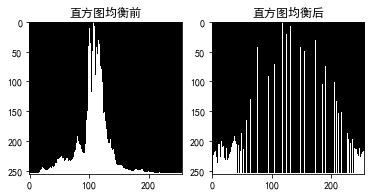

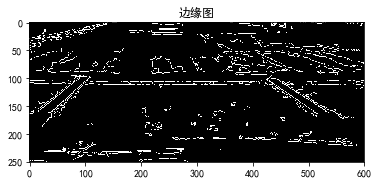

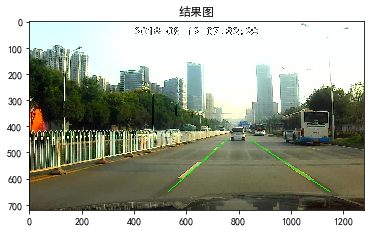

drawline: wh2.jpg
131.0
65 196


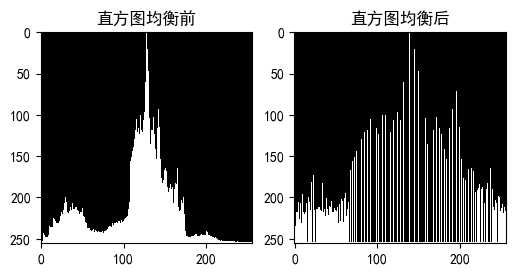

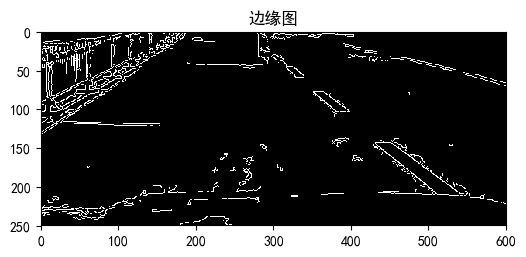

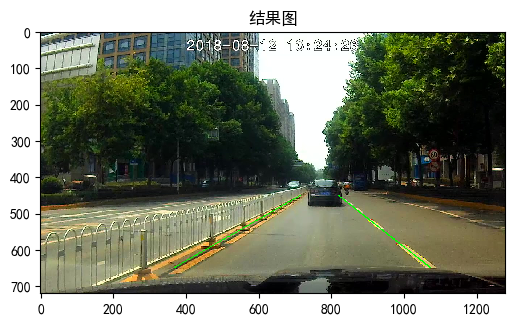

drawline: wh3.jpg
129.0
64 193


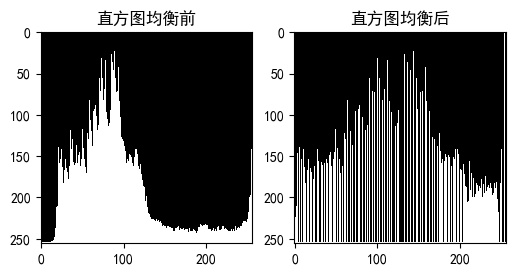

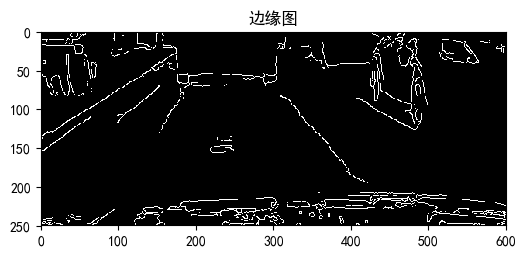

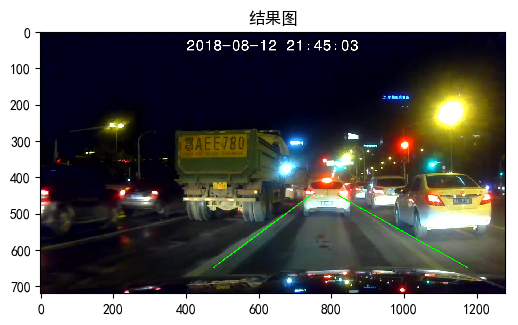

drawline: wh4.jpg
129.0
64 193


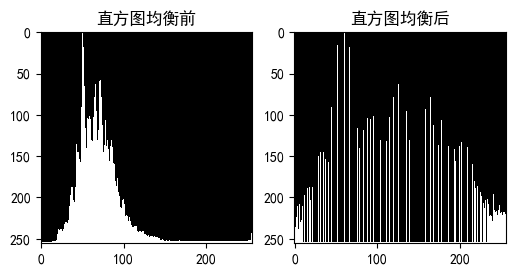

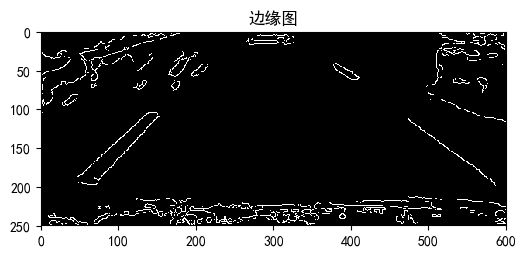

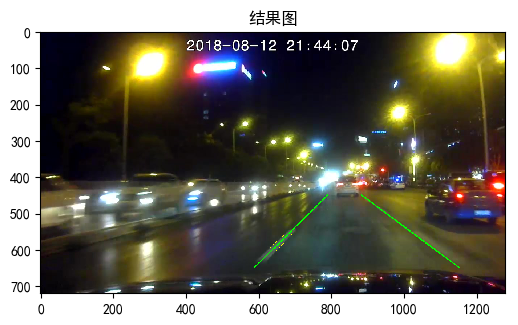

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
%matplotlib inline


# 定义自定义字体，文件名从1.b查看系统中文字体中来
def drawHist(hist):
    img = np.zeros((256, 256), np.uint8)
    r = max(hist) / 256
#     print(r)
    for i in range(0, 256):
        hist[i] = hist[i] / r
        cv2.line(img, (i, 255), (i, 255 - hist[i]), 255)
    return img

def drawLaneLine(filename):
    # 输出文件名
    print("drawline:", filename)

    # 读取图片
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)

    # 灰度化
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 高斯平滑
    img1 = cv2.GaussianBlur(img1, (3, 3), 1)

    # 设定ROI
    x, y, w, h = 550, 440, 600, 250
    imCrop = img1[y:y + h, x:x + w]

    # 设定车道线上下边界
    TOP = 450
    BOTTOM = 650

    # 获取直方图
    hist1 = cv2.calcHist([imCrop], [0], None, [256], [0.0, 255.0])
#     print(max(hist1))


    ####《《《    start获取直方图自写代码  提示 ：接收变量为histImg1    》》》    ####
    
    histImg1=drawHist(hist1)
    
    #### 《《《     end获取直方图自写代码      》》》   ####
    
    

    # 直方图均衡
    imCropEqu = cv2.equalizeHist(imCrop)

    # 获取并绘制均衡化后的直方图
    hist2 = cv2.calcHist([imCropEqu], [0], None, [256], [0.0, 255.0])
    histImg2 = drawHist(hist2)

    # 高低阈值自动设定:
    # 建议设置 高低阈值比 2:1 或 3:1
    # 获取当前图像的中位灰度值
    v = np.median(imCropEqu)
    print(v)
    # sigma=0.33时，高低阈值比2:1 , sigma=0.5时 高低阈值比3:1
    sigma = 0.5
    thrhigh = int(min(255 * 1.414, (1.0 + sigma) * v))
    thrlow = int(max(0, (1.0 - sigma) * v))

    print(thrlow, thrhigh)

    # 用Canny求img的边缘图像，高低阈值分别设定为thrhigh和thrlow，并保存至edges
    edges = cv2.Canny(imCropEqu, thrlow, thrhigh)

    # 通过霍夫变换函数得到线段的四个点并存于lines中
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 40, 30, 20)

    # 左右上下车道线平均横向坐标值
    LTAvg = 0
    LBAvg = 0
    RTAvg = 0
    RBAvg = 0
    LCount = 0
    RCount = 0

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if y1 > y2:
                x2, y2, x1, y1 = line[0]

            if x2 == x1:
                Gra = 99999
            else:
                Gra = (y2 - y1) / (x2 - x1)

            # 通过斜率 过滤近乎横线的线
            # -----在下方填入你的条件，过滤掉近乎横线的线-----
            if Gra < 0.1 and Gra > -0.1:
                # -----在上方填入你的条件，过滤掉近乎横线的线-----
                continue

            # 通过斜率和坐标 过滤非车道线的线。
            # 中心点左边的线的斜率大于0，中心点右边线的斜率小于0的 过滤掉。
            # -----在下方填入你的条件，过滤掉非车道线的线-----
            if (Gra > 0 and x1 < w / 2) or (Gra < 0 and x1 > x1 < w / 2):
                # -----在上方填入你的条件，过滤掉非车道线的线-----
                continue

            # 调试用：画点(x1,y1) 和 检出的过滤后的直线
            cv2.circle(img, (x + x1, y + y1), 0, (0, 0, 255), 2)
            cv2.line(img, (x + x1, y + y1), (x + x2, y + y2), (0, 255, 255), 1)

            # 延长直线，并求取左右车道线上下端点的横坐标总和，为求平均值做准备。
            xt = int((x + x1) + (TOP - y - y1) / Gra)
            xb = int((x + x2) + (BOTTOM - y - y2) / Gra)
            if Gra >= 0:
                RTAvg += xt
                RBAvg += xb
                RCount += 1
            else:
                LTAvg += xt
                LBAvg += xb
                LCount += 1

    # 并求取左右车道线上下端点的横坐标的平均值，并画出车道线
    if (LCount != 0):
        LTAvg = int(LTAvg / LCount)
        LBAvg = int(LBAvg / LCount)
        ####《《《    start求取左车道线自写代码  提示 ：利用cv2.line() 解决  》》》    ####
        cv2.line(img,(LTAvg,TOP),(LBAvg,BOTTOM),(0, 255, 0),2)

        #### 《《《     end求取左车道线自写代码      》》》   ####
#         cv2.line(img, (LTAvg, TOP), (LBAvg, BOTTOM), (0, 255, 0), 2)

    if (RCount != 0):
        RTAvg = int(RTAvg / RCount)
        RBAvg = int(RBAvg / RCount)
        cv2.line(img, (RTAvg, TOP), (RBAvg, BOTTOM), (0, 255, 0), 2)

    # 设置画板标题字体
    # plt.rcParams['font.sans-serif'] = [u'DejaVu Sans']

    # 创建第一个画板，标题为直方图均衡前后
    plt.figure(1)
    plt.subplot(1, 2, 1)
    plt.title(u"直方图均衡前")
    plt.imshow(histImg1, cmap="gray")

    plt.subplot(1, 2, 2)
    plt.title(u"直方图均衡后")
    plt.imshow(histImg2, cmap="gray")

    # 创建第一个画板，标题为边缘图
    plt.figure(2)
    plt.title(u"边缘图")

    # 在第一个画板中绘制边缘图
    plt.imshow(edges, cmap="gray")

    # 创建第二个画板，标题为结果图
    plt.figure(3)
    plt.title(u"结果图")

    # 在第二个画板中绘制结果图
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    # 调整dpi，使显示尺寸变大。
    plt.rcParams['figure.dpi'] = 100

    # 显示plt
    plt.show()


if __name__ == "__main__":
    # 文件路径填写当前环境的路径 和本文件同意文件下 可使用drawLaneLine("wh1.jpg")
    drawLaneLine("wh1.jpg")
    drawLaneLine("wh2.jpg")
    drawLaneLine("wh3.jpg")
    drawLaneLine("wh4.jpg")
    

Using TensorFlow backend.


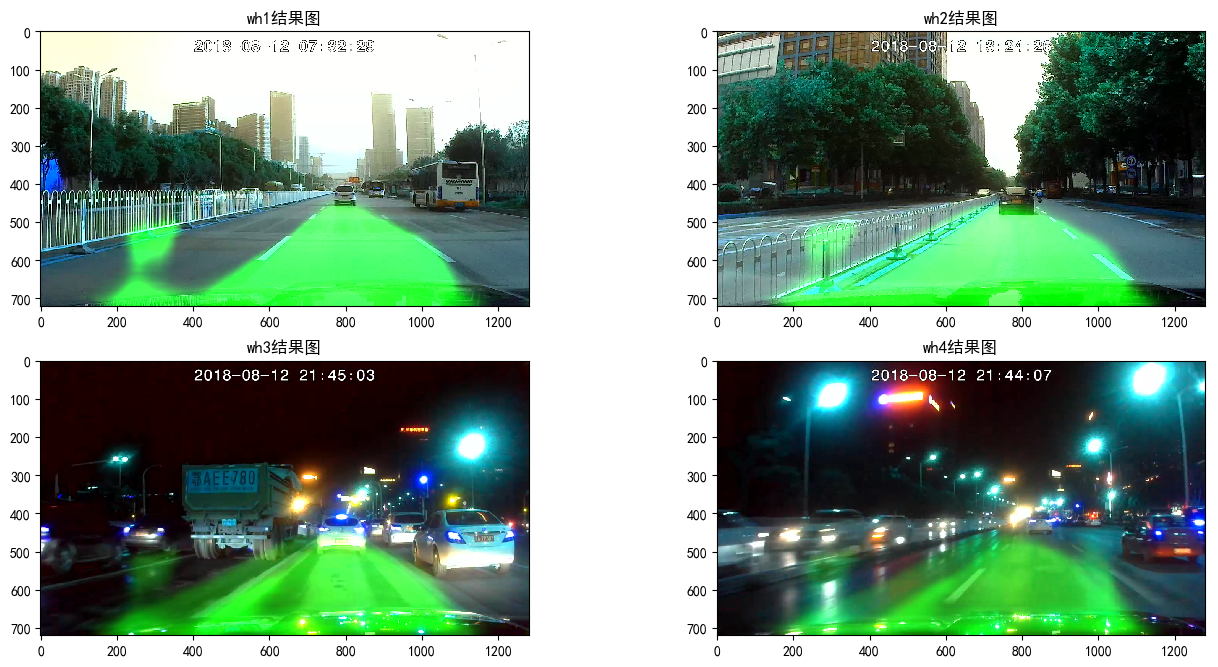

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import cv2
from scipy.misc import imresize
from moviepy.editor import VideoFileClip
#from IPython.display import HTML
from keras.models import load_model

# Load Keras model
model = load_model('full_CNN_model.h5')

# Class to average lanes with
class Lanes():
    def __init__(self):
        self.recent_fit = []
        self.avg_fit = []

def road_lines(image):
    """ Takes in a road image, re-sizes for the model,
    predicts the lane to be drawn from the model in G color,
    recreates an RGB image of a lane and merges with the
    original road image.
    """

    # Get image ready for feeding into model
    small_img = imresize(image, (80, 160, 3))
    small_img = np.array(small_img)
    small_img = small_img[None,:,:,:]

    # Make prediction with neural network (un-normalize value by multiplying by 255)
    prediction = model.predict(small_img)[0] * 255

    # Add lane prediction to list for averaging
    lanes.recent_fit.append(prediction)
    # Only using last five for average
    if len(lanes.recent_fit) > 5:
        lanes.recent_fit = lanes.recent_fit[1:]

    # Calculate average detection
    lanes.avg_fit = np.mean(np.array([i for i in lanes.recent_fit]), axis = 0)

    # Generate fake R & B color dimensions, stack with G
    blanks = np.zeros_like(lanes.avg_fit).astype(np.uint8)  
    lane_drawn = np.dstack((blanks, lanes.avg_fit, blanks))

    # Re-size to match the original image
    lane_image = imresize(lane_drawn, (720,1280, 3))

    # Merge the lane drawing onto the original image
    result = cv2.addWeighted(image, 1, lane_image, 1, 0)

    return result

lanes = Lanes()

# Where to save the output video
# Image_output = 'output_freeway_clip.mp4'

# # Location of the input video
# #clip1 = VideoFileClip("project_video.mp4")
# clip1 = VideoFileClip("freeway_clip.mp4")

# vid_clip = clip1.fl_image(road_lines)
# vid_clip.write_videofile(vid_output, audio=False)


# 读取图片并处理图片
Img1 = cv2.imread('wh1.jpg', cv2.IMREAD_UNCHANGED)
Img1_out=road_lines(Img1)

Img2 = cv2.imread('wh2.jpg', cv2.IMREAD_UNCHANGED)
Img2_out=road_lines(Img2)

Img3 = cv2.imread('wh3.jpg', cv2.IMREAD_UNCHANGED)
Img3_out=road_lines(Img3)

Img4 = cv2.imread('wh4.jpg', cv2.IMREAD_UNCHANGED)
Img4_out=road_lines(Img4)

#画图
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.title(u"wh1结果图")
plt.imshow(Img1_out)
plt.subplot(2,2,2)
plt.title(u"wh2结果图")
plt.imshow(Img2_out)
plt.subplot(2,2,3)
plt.title(u"wh3结果图")
plt.imshow(Img3_out)
plt.subplot(2,2,4)
plt.title(u"wh4结果图")
plt.imshow(Img4_out)

* 深度学习的结果还不是很好，还需要进一步优化